# Обнаружение статистически значимых отличий в уровнях экспрессии генов больных раком

## Описание используемых данных

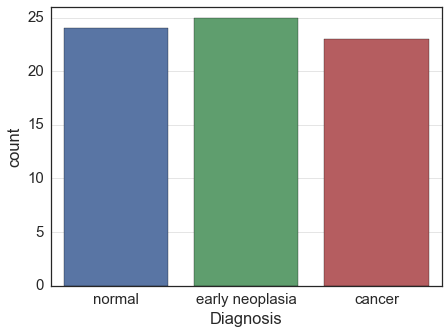

In [1]:
import pandas as pd
import scipy
from statsmodels.stats.weightstats import *

In [2]:
gene = pd.read_csv('gene_high_throughput_sequencing.csv', sep = ',')
gene.head()

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917


In [3]:
gene.shape

(72, 15750)

In [4]:
gene.Diagnosis.value_counts()

early neoplasia    25
normal             24
cancer             23
Name: Diagnosis, dtype: int64

In [5]:
gene.dropna().shape

(72, 15750)

### Часть 1: применение t-критерия Стьюдента

В первой части нужно применить критерий Стьюдента для проверки гипотезы о равенстве средних в двух независимых выборках. Применить критерий для каждого гена нужно дважды:

для групп normal (control) и early neoplasia (treatment)

для групп early neoplasia (control) и cancer (treatment)

В качестве ответа в этой части задания необходимо указать количество статистически значимых отличий, которые вы нашли с помощью t-критерия Стьюдента, то есть число генов, у которых p-value этого теста оказался меньше, чем уровень значимости.

In [6]:
gene_normal = gene[gene.Diagnosis=='normal']
gene_early = gene[gene.Diagnosis=='early neoplasia']
gene_cancer = gene[gene.Diagnosis=='cancer']

In [7]:
pvalue_normal_early = [scipy.stats.ttest_ind(gene_normal.iloc[:,i],gene_early.iloc[:,i], equal_var = False).pvalue for i  in range(2,gene.shape[1])]

In [11]:
pvalue_stat1 = np.array(pvalue_normal_early)<0.05

In [12]:
sum(pvalue_stat1)

1575

In [13]:
pvalue_early_cancer = [scipy.stats.ttest_ind(gene_early.iloc[:,i],gene_cancer.iloc[:,i], equal_var = False).pvalue for i  in range(2,gene.shape[1])]

In [14]:
pvalue_stat2 = np.array(pvalue_early_cancer)<0.05

In [15]:
sum(pvalue_stat2)

3490

###  Часть 2: поправка методом Холма

In [16]:
import statsmodels.stats.multitest as smm
from statsmodels.sandbox.stats.multicomp import multipletests

In [17]:
#multipletests(auc_corr_p, alpha = 0.05, method = 'fdr_bh')
rej1, pval_corr1 = smm.multipletests(pvalue_stat1, alpha=0.025, method='holm')[:2]

In [18]:
fold_name1 = gene.columns[2:][pval_corr1<0.025]

In [19]:
rej2, pval_corr2 = smm.multipletests(pvalue_stat2, alpha=0.025, method='holm')[:2]

In [20]:
fold_name2 = gene.columns[2:][pval_corr2<0.025]

In [21]:
fold_change_coef1 = [gene_early[i].mean()/gene_normal[i].mean() if gene_normal[i].mean() < gene_early[i].mean() else -gene_normal[i].mean()/gene_early[i].mean() for i in fold_name1]

In [23]:
sum(np.array(fold_change_coef1)>1.5)

15

In [24]:
fold_change_coef2 = [gene_cancer[i].mean()/gene_early[i].mean() if gene_cancer[i].mean() > gene_early[i].mean() else -gene_early[i].mean()/gene_cancer[i].mean() for i in fold_name2]

In [25]:
sum(abs(np.array(fold_change_coef2))>1.5 )

114

In [26]:
def write_answer(x):
    with open("ans.txt", "w") as fout:
        fout.write(str(x))

In [27]:
write_answer(524)

### Часть 3: поправка методом Бенджамини-Хохберга

In [28]:
rej1, pval_corr1 = smm.multipletests(pvalue_stat1, alpha=0.025, method='fdr_bh')[:2]

In [29]:
rej2, pval_corr2 = smm.multipletests(pvalue_stat2, alpha=0.025, method='fdr_bh')[:2]